<a href="https://colab.research.google.com/github/kb10241024/BTP_2k22/blob/main/Copy_of_BTP_NER_13_03_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing req packages

In [1]:
!pip install conllu

In [ ]:
!pip install indic-transliteration

In [3]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 31.9 MB/s 
     |████████████████████████████████| 895 kB 46.9 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 127 kB 44.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.1.3 requires urllib3[secure,socks]~=1.26, but you have urllib3 1.25.11 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.

### Importing Libraries

In [4]:
from collections import Counter
import conllu
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import unicodedata
 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense
from keras.layers import TimeDistributed, Dropout, Bidirectional

In [5]:
# import the module
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFAutoModel, AutoTokenizer,BertTokenizer,TFBertModel
from sklearn.metrics import confusion_matrix,f1_score

## Attatching Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path_to_dataset='/content/drive/MyDrive/Acads/4-1/BTP/DATASET'
path_to_ner_hineng='/content/drive/MyDrive/Acads/4-1/BTP/DATASET/ner_hineng'

## Dataset Preparation

In [ ]:
# !pip install pyconll
# import pyconll
# train = pyconll.load.iter_from_file('/content/test.conll')
# # print(train)
# for sentence in train:
#   print(sentence.id)
#   for token in sentence:
#     print(token)
# #   print(sentence)

In [9]:
data=open('/content/drive/MyDrive/Acads/4-1/BTP/DATASET/ner_hineng/train.conll',mode='r',encoding='utf-8')
annotations=data.read()
# print(type(annotations))
# print(annotations[:100])

### Another DS

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/SilentFlame/Named-Entity-Recognition/master/Twitterdata/annotatedData.csv')
print(df.shape)
df.head(20)

(72143, 3)


,Sent,Word,Tag
0,sent: 0,Bahubali,B-Per
1,sent: 0,2,Other
2,sent: 0,ke,Other
3,sent: 0,liye,Other
4,sent: 0,line,Other
5,sent: 0,lag,Other
6,sent: 0,sakte,Other
7,sent: 0,hai,Other
8,sent: 0,desh,B-Org
9,sent: 0,ke,Other


### Data Cleaning

In [10]:
import re

text = "hey amazon - my package never   arrived https://www.amazon.com/gp/css/order-history?ref_=nav_orders_first please fix asap! @amazonhelp"
# text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)

In [12]:
def remove_links(text):
    """
    This function will remove all the occurrences of links.
    
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" after removal of all types of links.
        
    Example:
    Input : To know more about this website: kajalyadav.com  visit: https://kajalyadav.com//Blogs
    Output : To know more about this website: visit: <URL>    
    
    """
    
    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', "<URL>", text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", "<URL>", remove_https)
    return remove_com
  
print(remove_links(text))

hey amazon - my package never   arrived <URL> please fix asap! @amazonhelp


In [ ]:
# from bs4 import BeautifulSoup

# def strip_html_tags(text):
#     """ 
#     This function will remove all the occurrences of html tags from the text.
    
#     arguments:
#         input_text: "text" of type "String". 
                    
#     return:
#         value: "text" after removal of html tags.
        
#     Example:
#     Input : This is a nice place to live. <IMG>
#     Output : This is a nice place to live.  
#     """
#     # Initiating BeautifulSoup object soup.
#     soup = BeautifulSoup(text, "html.parser")
#     # Get all the text other than html tags.
#     stripped_text = soup.get_text(separator=" ")
#     return stripped_text

# txt="This is a nice place to live. <IMG>"  
# print(strip_html_tags(txt))

In [13]:
def remove_newlines_tabs(text):
    """
    This function will remove all the occurrences of newlines, tabs, and combinations like: \\n, \\.
    
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" after removal of newlines, tabs, \\n, \\ characters.
        
    Example:
    Input : This is her \\ first day at this place.\n Please,\t Be nice to her.\\n
    Output : This is her first day at this place. Please, Be nice to her. 
    
    """
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text
  
txt="This is her \\ first day at this place.\n Please,\t Be nice to her.\\n"
print(remove_newlines_tabs(txt))

This is her   first day at this place.  Please,  Be nice to her. 


In [14]:
def remove_whitespace(text):
    """ This function will remove extra whitespaces from the text
    arguments:
        input_text: "text" of type "String". 
    return:
        value: "text" after extra whitespaces removed .
        
    Example:
    Input : How   are   you   doing   ?
    Output : How are you doing ?     
    """
    pattern = re.compile(r'\s+') 
    Without_whitespace = re.sub(pattern, ' ', text)
    # There are some instances where there is no space after '?' & ')', 
    # So I am replacing these with one space so that It will not consider two words as one token.
    text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return text

print(remove_whitespace(text))

hey amazon - my package never arrived https://www.amazon.com/gp/css/order-history ? ref_=nav_orders_first please fix asap! @amazonhelp


In [15]:
def reducing_incorrect_character_repeatation(text):
    """
    This Function will reduce repeatition to two characters 
    for alphabets and to one character for punctuations.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Finally formatted text with alphabets repeating to 
        two characters & punctuations limited to one repeatition 
        
    Example:
    Input : Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)
    Output : Reallyy, Greeaatt !?.;:)
    
    """
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted
  
txt="Realllllllllyyyyy"#,   #AAP  @modi   Greeeeaaaatttt   !!!!?....;;;;:)"
print(reducing_incorrect_character_repeatation(txt))

Reallyy


In [16]:
# The code for removing special characters
def removing_special_characters(text):
    """Removing all the special characters except the one that is passed within 
       the regex to match, as they have imp meaning in the text provided.
       
    arguments:
         input_text: "text" of type "String".
    return:
        value: Text with removed special characters that don't require.
        
    Example: 
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?) 
    Output :  Hello, Kajal. This is $100.05 : the payment that you will recieve! Is this okay?
    
   """
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:#@$-,%.?!]+", ' ', text) 
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Formatted_Text

txt="Hello, K-a-j-a-l. Thi*s is $100.05 : the #payment @that you will recieve! (Is this okay?)"  
print(removing_special_characters(txt))

Hello, K a j a l. Thi*s is $100.05 : the #payment @that you will recieve! (Is this okay?)


In [17]:
text = "hey amazon - my package never   #arrived https://www.amazon.com/gp/css/order-history?ref_=nav_orders_first please fix asap! @amazonhelp"
print(removing_special_characters(text))

hey amazon my package never #arrived https: www.amazon.com gp css order history?ref nav orders first please fix asap! @amazonhelp


In [18]:
!pip install autocorrect

     |████████████████████████████████| 622 kB 5.2 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=18f08a7b2569f8b6a38e3dea117339c44acfc5d93196b9479cb3ed90847e9232
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect


In [19]:
# The code for spelling corrections
from autocorrect import Speller

def spelling_correction(text):
    ''' 
    This function will correct spellings.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Text after corrected spellings.
        
    Example: 
    Input : This is Oberois from Dlhi who came heree to studdy.
    Output : This is Oberoi from Delhi who came here to study.     
    
    '''
    # Check for spellings in English language
    spell = Speller(lang='en')
    Corrected_text = spell(text)
    return Corrected_text

txt="This is Oberois from Dlhi who came heree to studdy."
print(spelling_correction(txt))

This is Oberoi from Delhi who came here to study.


In [21]:
def text_cleaning(t,do_spell_correction=False):
  t=remove_links(t)
  t=removing_special_characters(t)
  t=remove_newlines_tabs(t)
  t=remove_whitespace(t)
  t=reducing_incorrect_character_repeatation(t)
  if(do_spell_correction):
    t=spelling_correction(t)
  return t

In [22]:
text = "hey amazon - my package never   #arrived https://www.amazon.com/gp/css/order-history?ref_=nav_orders_first please fix asap! @amazonhelp"
print(text_cleaning(text))

hey amazon my package never #arrived URL please fix asap! @amazonhelp


### Transliteration

In [23]:
# the text to be transliterated
text = "Aapa sabhii kaa yahaan svaagat hai."
# text="chalo"
# printing the transliterated text
print(text)
print(transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI))

Aapa sabhii kaa yahaan svaagat hai.
आअप सभी का यहान् स्वागत् है।


In [28]:
count=0
sen_id=[]
sentences=[]
for sen in annotations.strip().split("# sent_enum = "):
  if(len(sen)>0):
    count+=1
    idx=sen.find("\n")
    sen_id.append(sen[:idx])
    txt=[]
    for token in sen[idx+1:].strip().split('\n'):
      tok=token.split()
      # Text-Cleaning
      tok[0]=text_cleaning(tok[0])
      if(tok[1]=='hi'):
        tok[0]=transliterate(tok[0], sanscript.ITRANS, sanscript.DEVANAGARI)
      # else:
      #   tok[0]=spelling_correction(tok[0])
      txt.append(tok)
    sentences.append(txt)

print(count)

1243


In [27]:
print(sentences[1])

[['I', 'en', 'O'], ['liked', 'en', 'O'], ['a', 'en', 'O'], ['@YouTube', 'en', 'O'], ['video', 'en', 'O'], [' URL ', 'en', 'O'], ['ख़भि', 'hi', 'O'], ['Pअल्कोन्', 'hi', 'O'], ['Pए', 'hi', 'O'], ['आअसून्', 'hi', 'O'], ['ःऐ ', 'hi', 'O'], ['ख़िशोरे', 'hi', 'B-PERSON'], ['ख़ुमर्', 'hi', 'I-PERSON'], [' Vocal', 'en', 'O'], ['Cover', 'en', 'O'], ['By', 'en', 'O'], ['Stephen', 'en', 'B-PERSON'], ['Qadir', 'rest', 'I-PERSON']]


In [ ]:
tags=[]
words=[]
lang=[]
for id,sen in zip(sen_id,sentences):
  for tok in sen:
    lang.append(tok[1])
    words.append(tok[0])
    tags.append(tok[2])
words.append("<OOV>")
print(len(set(words)),len(words))
print(len(set(tags)))
print(Counter(tags))
print(len(set(lang)))
print(Counter(lang))

7947 21066
7
Counter({'O': 18843, 'B-PERSON': 963, 'B-PLACE': 455, 'I-PERSON': 411, 'B-ORGANISATION': 218, 'I-PLACE': 108, 'I-ORGANISATION': 67})
3
Counter({'en': 8198, 'hi': 6905, 'rest': 5962})


### EDA

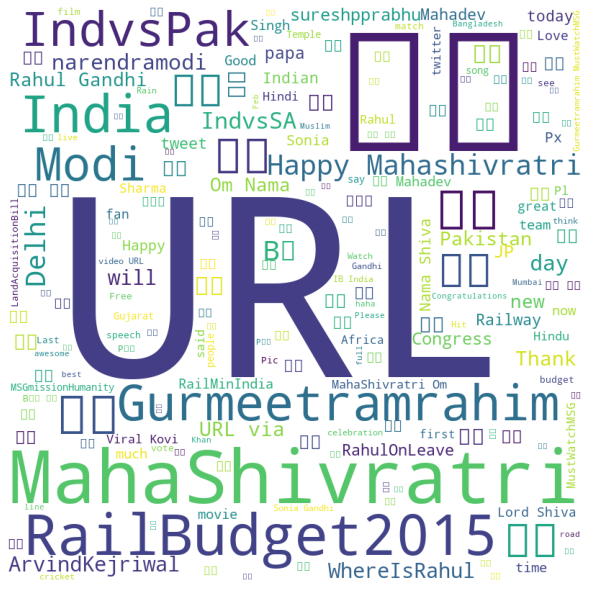

In [ ]:
# Wordcloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

dataset = ' '.join(words)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(dataset)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# def create_word_cloud(string):
#    maskArray = npy.array(Image.open("cloud.png"))
#    cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = set(STOPWORDS))
#    cloud.generate(string)
#    cloud.to_file("wordCloud.png")
# dataset = dataset.lower()
# create_word_cloud(dataset)

In [ ]:
d={'O': 18843, 'B-PERSON': 963, 'B-PLACE': 455, 'I-PERSON': 411, 'B-ORGANISATION': 218, 'I-PLACE': 108, 'I-ORGANISATION': 67}
d2={'B-PERSON': 963, 'B-PLACE': 455, 'I-PERSON': 411, 'B-ORGANISATION': 218, 'I-PLACE': 108, 'I-ORGANISATION': 67}

In [ ]:
# Import library
import pandas as pd
 
# Create Dataset {'en': 8198, 'hi': 6905, 'rest': 5962}
# df = pd.DataFrame([963,455,411,218,108,67], index=['B-PERSON', 'B-PLACE', 'I-PERSON','B-ORGANISATION','I-PLACE','I-ORGANISATION'], columns=['Values']) 
df = pd.DataFrame([8198,6905,5962], index=['en', 'hi','rest'], columns=['Values']) 

In [ ]:
# df=pd.DataFrame(d)
df

,Values
en,8198
hi,6905
rest,5962


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5237ecca50>],
      dtype=object)

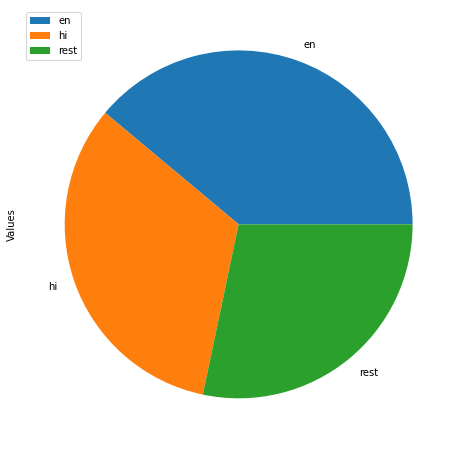

In [ ]:
# Make the Pie plot
df.plot(kind='pie', subplots=True, figsize=(8, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd435014490>],
      dtype=object)

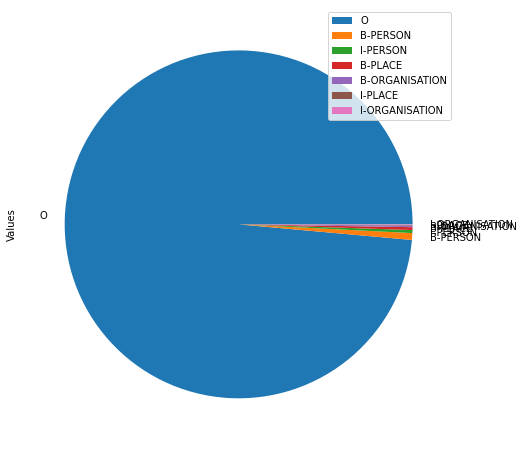

In [ ]:
import pandas as pd

t2i={'B-ORGANISATION': 0, 'B-PERSON': 1, 'O': 2, 'I-PERSON': 3, 'B-PLACE': 4, 'I-PLACE': 5, 'I-ORGANISATION': 6}
d3={'O': 39617, 'B-PERSON': 254, 'I-PERSON': 112, 'B-PLACE': 105, 'B-ORGANISATION': 61, 'I-PLACE': 24, 'I-ORGANISATION': 19}
df = pd.DataFrame([39617,254,112,105,61,24,19], index=['O','B-PERSON', 'I-PERSON', 'B-PLACE', 'B-ORGANISATION', 'I-PLACE', 'I-ORGANISATION'], columns=['Values']) 
df2 = pd.DataFrame([254,112,105,61,24,19], index=['B-PERSON', 'I-PERSON', 'B-PLACE', 'B-ORGANISATION', 'I-PLACE', 'I-ORGANISATION'], columns=['Values']) 

df.plot(kind='pie', subplots=True, figsize=(8, 8))

In [ ]:
max_len=0
min_len=0
avg_len=0
for sen in sentences:
  l=len(sen)
  if(l>max_len):
    max_len=l
  if(l<min_len):
    min_len=l
  avg_len+=l
avg_len/=len(sentences)

print("MIN Length of sentences is",min_len)
print("MAX Length of sentences is",max_len)
print("AVG Length of sentences is",avg_len)

MIN Length of sentences is 0
MAX Length of sentences is 36
AVG Length of sentences is 16.946902654867255


### Creating Word & Tag dictionary

In [ ]:
# Creating a vocabulary
un_words = list(set(words))
un_words.append("<PAD>")
n_words = len(un_words)
print("Length of vocabulary = ",n_words)
 
un_tags = list(set(tags))
# Adding tag for <PAD>
# un_tags.append("<PAD>")
n_tags = len(un_tags)
print("\nnumber of tags = ",n_tags)
# print(un_tags)
 
# Creating words to indices dictionary.
word2idx = {w: i for i, w in enumerate(un_words)}
# Creating tags to indices dictionary.
tag2idx = {t: i for i, t in enumerate(un_tags)}
print(tag2idx)

Length of vocabulary =  7948

number of tags =  7
{'I-PERSON': 0, 'O': 1, 'B-ORGANISATION': 2, 'B-PLACE': 3, 'B-PERSON': 4, 'I-PLACE': 5, 'I-ORGANISATION': 6}


In [ ]:
print(un_words)

['Particular', 'Zee', 'दूब्त', 'BilliMora', 'हरने', 'अब्', 'तेरि', 'डेख', 'करदेन्', '#DevonKeDevMahadev', 'CNN', 'ख़मरि', 'men', 'चुतिय', 'waiting', 'Does', '@CaptAbhimanyu', 'बोल्', 'नय', 'BSK', 'ग़ाट्E', 'षिव', 'peasant', '5 5', 'Journalist', 'Sign', 'Hindustani', 'against', ':) ', 'HY', 'mileage', '@ःउस्न्ख़ःअथियर्', 'ंअस्तिज़ादे', 'Girodhpuri', 'Model', 'Education', 'ministry', '#AMA', 'मुल्क्', '@rvmoorthyhindu', 'ण', 'policies', 'Uttarakhand', 'Bअम्', 'Vastraadi', 'Ryan', 'मैन्', 'Glossary', '@तथगत२', 'ब्च्', 'तुम्हार', 'handsome', 'लल्', 'कत्', 'Shivaji', 'cleaned', '#ंअहकलेश्वर्', '@एये नक्शिरन्', 'घुमके', 'ग्ग्यी', '@NDTVProfit', 'Nova', '#02Feb15', 'Charm', 'तुने', 'all', '@NeelakshiGswm', 'plans', 'pls', 'produce', '#आयुथEऴुथु', 'BI', 'Sosa', 'Chennai', '11:00', 'Haryana', '@MTVRoadies', 'Shakira ', 'अन्खोन्', 'व्जह्', 'traitors', 'heavens', 'fb', '33', 'केने', 'देय्', 'parcel', 'Facts', 'पे', '@RailMinIndia', 'बदओ', 'कत्न', '@BhagwanUvach', 'ties', 'पुरि', 'परदे', 'Biopic', 'in

In [ ]:
# Converting words to indices for test sentences (Features)
MAXLEN=128 #36

# X = [[word2idx[w[0]] for w in s] for s in sentences]
X = [' '.join([w[0] for w in s]) for s in sentences]

'''
Padding train and test sentences to 32 words.
Sentences of length greater than 32 words are truncated.
Sentences of length less than 32 words are padded with a high value.
'''
# X = pad_sequences(maxlen=MAXLEN, sequences=X, padding="post", truncating="post", value=n_words - 1)
print(type(X),len(X))
print(X[:2])

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
encoded_X = tokenizer(X, padding='max_length', truncation=True, max_length=MAXLEN, return_tensors='tf').input_ids
print(type(encoded_X))
print(encoded_X.shape)

<class 'list'> 1243
['Gully cricket चल् रह हैन् यह   ( Sonia )  Gandhi  ', 'I liked a @YouTube video  URL  ख़भि Pअल्कोन् Pए आअसून् ःऐ  ख़िशोरे ख़ुमर्  Vocal Cover By Stephen Radio']


Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1243, 128)


In [ ]:
# ### Checking what should be max_length while encoding
# from statistics import mean

# text_lens=[]
# enc_lens=[]
# for s in X:
#   text_lens.append(len(s.split()))
#   enc=tokenizer(s, return_tensors='tf').input_ids
#   enc_lens.append(enc.shape[1])
#   # print(s)
#   # print(enc)
#   # print(len(s.split()))
#   # print(enc.shape[1])
#   # enc_lens.append(enc.shape)


# print(min(text_lens),min(enc_lens))
# print(max(text_lens),max(enc_lens))
# print(mean(text_lens),mean(enc_lens))

In [ ]:
# print(encoded_X[:5])
# print(encoded_X.shape)

In [ ]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding tag labels to 180 words.
y = pad_sequences(maxlen=MAXLEN, sequences=y, padding="post", truncating="post", value=tag2idx["O"])

print(tag2idx)
print(Counter(list(np.array(y).flatten())))

# Making labels in one hot encoded form for DL model
y = [to_categorical(i, num_classes=n_tags) for i in y]

{'I-PERSON': 0, 'O': 1, 'B-ORGANISATION': 2, 'B-PLACE': 3, 'B-PERSON': 4, 'I-PLACE': 5, 'I-ORGANISATION': 6}
Counter({1: 156882, 4: 963, 3: 455, 0: 411, 2: 218, 5: 108, 6: 67})


In [ ]:
# print(X.shape)
print(len(y))
print(y[0].shape)
print(np.array(y).shape)
# print(y[0])

1243
(128, 7)
(1243, 128, 7)


### Model

In [ ]:
# from transformers import pipeline
# unmasker = pipeline('fill-mask', model='bert-base-multilingual-uncased')
# sen='I am [MASK] की आज खेलने चल सकते हे क्या?'
# # sen='I am [MASK] ki aaj khelne chal sakte he kya?'
# # unmasker("Hello I'm a [MASK] model.")
# unmasker(sen)

# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
# model = TFBertModel.from_pretrained("bert-base-multilingual-uncased")
# text = ["Replace me by any text you'd like."]
# encoded_input = tokenizer(text,padding=True,truncation=True,max_length=36, return_tensors='tf')
# print(encoded_input)

In [ ]:
LSTM_N=256
BS=32

transformer_name = 'bert-base-multilingual-uncased' # 'bert-base-multilingual-cased'
# First load the transformer layer
transformer_encoder = TFBertModel.from_pretrained(transformer_name)
# This will be the input tokens 
input_ids = Input(shape=(MAXLEN,), dtype=tf.int32, name="input_ids")
# token_type_ids = tf.keras.layers.Input(shape=(MAXLEN,), dtype=tf.int32)
# attention_mask = tf.keras.layers.Input(shape=(MAXLEN,), dtype=tf.int32)

# Now, we encode the text using the transformers we just loaded
model = transformer_encoder(input_ids)[0]

# model = Bidirectional(LSTM(units=LSTM_N, recurrent_activation='relu', return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(model)
# model = Bidirectional(LSTM(units=LSTM_N, recurrent_activation='relu', return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(model)

# # Adding a TimeDistributedDense, to applying a Dense layer on each 180 timesteps
# model = Dropout(0.5)(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model) # softmax output layer

# It's time to build and compile the model
model = Model(inputs=input_ids, outputs=out)
# model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)

# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.Adagrad(lr=2e-5)
# metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]

# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.compile(
    Adagrad(lr=1e-5), # Experiment with lr
    loss='categorical_crossentropy',  
    metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]
)
# model.compile(optimizer="adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

# model.summary()

Downloading:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  167356416
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             128, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
history = model.fit(encoded_X, np.array(y), batch_size=BS, epochs=25, validation_split=0.15, verbose=1)

Epoch 1/25
33/33 [==============================] - 1309s 39s/step - loss: 1.2358 - accuracy: 0.7234 - false_negatives: 122118.0000 - false_positives: 304.0000 - val_loss: 0.6995 - val_accuracy: 0.9596 - val_false_negatives: 5513.0000 - val_false_positives: 166.0000
Epoch 2/25
33/33 [==============================] - 1295s 39s/step - loss: 0.5859 - accuracy: 0.9528 - false_negatives: 31605.0000 - false_positives: 804.0000 - val_loss: 0.3562 - val_accuracy: 0.9692 - val_false_negatives: 1482.0000 - val_false_positives: 285.0000
Epoch 3/25
33/33 [==============================] - 1276s 39s/step - loss: 0.3591 - accuracy: 0.9665 - false_negatives: 12523.0000 - false_positives: 1213.0000 - val_loss: 0.2400 - val_accuracy: 0.9707 - val_false_negatives: 979.0000 - val_false_positives: 320.0000
Epoch 4/25
33/33 [==============================] - 1276s 39s/step - loss: 0.2647 - accuracy: 0.9703 - false_negatives: 8842.0000 - false_positives: 1374.0000 - val_loss: 0.1889 - val_accuracy: 0.9720 

In [ ]:
print(encoded_X.shape)
print(np.array(y).shape)
print(len(y))
print(y[0][0])

(1243, 128)
(1243, 128, 7)
1243
[0. 1. 0. 0. 0. 0. 0.]


### Test-Data

In [ ]:
# print(tokenizer.vocab_size)
# print(tokenizer.vocab)

In [ ]:
test_data=open('/content/drive/MyDrive/Acads/4-1/BTP/DATASET/ner_hineng/dev.conll',mode='r',encoding='utf-8')
test_data=test_data.read()
print(type(test_data))

<class 'str'>


In [ ]:
test_count=0
test_sen_id=[]
test_sentences=[]
for sen in test_data.strip().split("# sent_enum = "):
  if(len(sen)>0):
    test_count+=1
    idx=sen.find("\n")
    test_sen_id.append(sen[:idx])
    txt=[]
    for token in sen[idx+1:].strip().split('\n'):
      tok=token.split()
      # Text-Cleaning
      tok[0]=text_cleaning(tok[0])
      if(tok[1]=='hi'):
        tok[0]=transliterate(tok[0], sanscript.ITRANS, sanscript.DEVANAGARI)
      else:
        tok[0]=spelling_correction(tok[0])
      txt.append(tok)
    test_sentences.append(txt)

print(test_count)

314


In [ ]:
max_len=0
min_len=0
avg_len=0
for sen in test_sentences:
  l=len(sen)
  if(l>max_len):
    max_len=l
  if(l<min_len):
    min_len=l
  avg_len+=l
avg_len/=len(test_sentences)

print(len(test_sentences))
print("MIN Length of sentences is",min_len)
print("MAX Length of sentences is",max_len)
print("AVG Length of sentences is",avg_len)

314
MIN Length of sentences is 0
MAX Length of sentences is 34
AVG Length of sentences is 17.0828025477707


In [ ]:
print(test_sentences[3])

[['T', 'en', 'O'], ['@AamAadmiParty', 'en', 'O'], [':', 'rest', 'O'], ['National', 'en', 'B-ORGANISATION'], ['Disciplinary', 'en', 'I-ORGANISATION'], ['Committee', 'en', 'I-ORGANISATION'], ['has', 'en', 'O'], ['expelled', 'en', 'O'], ['Yogendra', 'en', 'B-PERSON'], ['Yadav', 'rest', 'I-PERSON'], [',', 'rest', 'O'], ['Peasant', 'en', 'B-PERSON'], ['Bहुशन्', 'hi', 'I-PERSON'], [',', 'rest', 'O'], ['Prof', 'en', 'O'], ['Anand', 'en', 'B-PERSON'], ['and', 'en', 'O'], ['Ajit', 'en', 'B-PERSON'], ['ज़्ह', 'hi', 'I-PERSON'], ['from', 'en', 'O'], ['AP', 'rest', 'B-ORGANISATION'], ['.', 'rest', 'O'], ['Px', 'rest', 'O'], [':', 'rest', 'O'], ['http', 'en', 'O']]


In [ ]:
# Converting words to indices for test sentences (Features)
# X_test = [[word2idx[w[0]] if w in un_words else word2idx["<OOV>"] for w in s] for s in test_sentences]
X_test = [" ".join([w[0] for w in s]) for s in test_sentences]

'''
Padding train and test sentences to 32 words.
Sentences of length greater than 32 words are truncated.
Sentences of length less than 32 words are padded with a high value.
'''
# X_test = pad_sequences(maxlen=MAXLEN, sequences=X_test, padding="post", truncating="post", value=n_words - 1)
# print(X_test.shape)

encoded_X_test = tokenizer(X_test, padding=True, truncation=True,max_length=78, return_tensors='tf').input_ids
print(type(encoded_X_test))
print(encoded_X_test.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(314, 63)


In [ ]:
y_test=[[tag2idx[w[2]] for w in s] for s in test_sentences]
# Padding tag labels to 180 words.
y_test_pad = pad_sequences(maxlen=MAXLEN, sequences=y_test, padding="post", truncating="post", value=tag2idx["O"])
print(y_test_pad.shape)

(314, 128)


In [ ]:
print(tag2idx)

{'I-PERSON': 0, 'O': 1, 'B-ORGANISATION': 2, 'B-PLACE': 3, 'B-PERSON': 4, 'I-PLACE': 5, 'I-ORGANISATION': 6}


In [ ]:
print(len(test_sentences[3]))
print(test_sentences[3])
print(y_test[3])
print(y_test_pad[3])

25
[['T', 'en', 'O'], ['@AamAadmiParty', 'en', 'O'], [':', 'rest', 'O'], ['National', 'en', 'B-ORGANISATION'], ['Disciplinary', 'en', 'I-ORGANISATION'], ['Committee', 'en', 'I-ORGANISATION'], ['has', 'en', 'O'], ['expelled', 'en', 'O'], ['Yogendra', 'en', 'B-PERSON'], ['Yadav', 'rest', 'I-PERSON'], [',', 'rest', 'O'], ['Peasant', 'en', 'B-PERSON'], ['Bहुशन्', 'hi', 'I-PERSON'], [',', 'rest', 'O'], ['Prof', 'en', 'O'], ['Anand', 'en', 'B-PERSON'], ['and', 'en', 'O'], ['Ajit', 'en', 'B-PERSON'], ['ज़्ह', 'hi', 'I-PERSON'], ['from', 'en', 'O'], ['AP', 'rest', 'B-ORGANISATION'], ['.', 'rest', 'O'], ['Px', 'rest', 'O'], [':', 'rest', 'O'], ['http', 'en', 'O']]
[1, 1, 1, 2, 6, 6, 1, 1, 4, 0, 1, 4, 0, 1, 1, 4, 1, 4, 0, 1, 2, 1, 1, 1, 1]
[1 1 1 2 6 6 1 1 4 0 1 4 0 1 1 4 1 4 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# print(Counter(y_test_pad.view(-1,).to_list()))
print(y_test_pad.shape)
y_test_pad_list=y_test_pad.flatten().tolist()
print(y_test_pad.shape)
print(len(y_test_pad_list))
print(Counter(y_test_pad_list))

(314, 128)
(314, 128)
40192
Counter({1: 39617, 4: 254, 0: 112, 3: 105, 2: 61, 5: 24, 6: 19})


In [ ]:
# Predicting on trained model
pred = model.predict(encoded_X_test)
print("Predicted Probabilities on Test Set:\n",pred.shape)
# taking tag class with maximum probability
pred_index = np.argmax(pred, axis=-1)
print("Predicted tag indices: \n",pred_index.shape)
pred_index_list=pred_index.flatten().tolist()
print(len(pred_index_list))
print(Counter(pred_index_list))

ValueError: ignored

In [ ]:
def compute_predicted_tags(pred,threshold):
  pred_index=[]
  for y_s in pred:
    pred_s=[]
    for t in y_s:
      # print(t)
      i1=i2=0
      p1=p2=0
      for i,p in enumerate(t):
        if(p>p1):
          i2,i1=i1,i
          p2,p1=p1,p
        elif(p>p2):
          i2=i
          p2=p
      if(i1==tag2idx["O"]):
        if(t[i1]>threshold):
          pred_s.append(i1)
        else:
          pred_s.append(i2)
      else:
        pred_s.append(i1)
    pred_index.append(pred_s)
  pred_index=np.array(pred_index)
  return pred_index

# pred_index=[]
# for y_s in pred:
#   pred_s=[]
#   for t in y_s:
#     # print(t)
#     i1=i2=0
#     p1=p2=0
#     for i,p in enumerate(t):
#       if(p>p1):
#         i2,i1=i1,i
#         p2,p1=p1,p
#       elif(p>p2):
#         i2=i
#         p2=p
#     if(i1==tag2idx['O']):
#       if(t[i1]>threshold):
#         pred_s.append(i1)
#       else:
#         pred_s.append(i2)
#     else:
#       pred_s.append(i1)
#   pred_index.append(pred_s)
# pred_index=np.array(pred_index)

In [ ]:
def get_best_threshold(pred,f1_avg_technnique='macro'):
  best_thres=0.2
  best_score=0.0
  y_act = y_test_pad.flatten().tolist()
  for thres in range(1,100,1):
    thres/=100.0
    pred_index=compute_predicted_tags(pred,thres)
    y_pred=pred_index.flatten().tolist()
    score=f1_score(y_act, y_pred, average=f1_avg_technnique)
    # print(f'{f1_avg_technnique} F1-score of {score} at threshold = {thres}')
    if(score>best_score):
      best_score=score
      best_thres=thres
  return best_thres,best_score

In [ ]:
thres,f1=get_best_threshold(pred)
print(f'Best f1-score of {f1} at threshold = {thres}')
pred_index=compute_predicted_tags(pred,thres)

In [ ]:
print(pred_index.shape)
pred_index_list=pred_index.flatten().tolist()
print(len(pred_index_list))
print(Counter(pred_index_list))

In [ ]:
pred[0][:2]

In [ ]:
y_act,y_pred = y_test_pad.flatten().tolist(), pred_index.flatten().tolist()
print(y_act[:10])
print(y_pred[:10])

In [ ]:
print(Counter(pred_index.flatten().tolist()))

In [ ]:
accuracy=0
for y_a,y_p in zip(y_act,y_pred):
  if(y_a==y_p):
    accuracy+=1
accuracy/=len(y_act)
print(accuracy)

In [ ]:
print(f1_score(y_act, y_pred, average='macro'))
print(f1_score(y_act, y_pred, average='micro'))
print(f1_score(y_act, y_pred, average='weighted'))
print(f1_score(y_act, y_pred, average=None))
cm=confusion_matrix(y_act, y_pred)
print(cm)

In [ ]:
# print(list(tag2idx.keys()))
tags=list(tag2idx.keys())
print(tags)
tags_hard=tags
for i in range(0,len(tags_hard)):
  tags_hard[i]=tags_hard[i][0:5]
print(tags_hard)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot(1,1,1)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# tags=list(tag2idx.keys())
# tags.reverse()
ax.xaxis.set_ticklabels(tags_hard); ax.yaxis.set_ticklabels(tags_hard);

# Following Github
[Lince](https://github.com/huggingface/datasets/blob/master/datasets/lince/lince.py)

In [ ]:
import csv
import os
import re
import textwrap
from itertools import groupby

In [ ]:
!pip install datasets

     |████████████████████████████████| 311 kB 4.9 MB/s 
     |████████████████████████████████| 243 kB 9.1 MB/s 
     |████████████████████████████████| 67 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 10.0 MB/s 
     |████████████████████████████████| 133 kB 26.0 MB/s 
     |████████████████████████████████| 144 kB 26.3 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 27.0 MB/s 


In [ ]:
import datasets

### Citations and Dataset Configuration


1.   _CITATION
2.   _DESCRIPTION
3.  _LINCE_URL
4.  _DATASET_CITATIONS

In [ ]:
_CITATION = """\
@inproceedings{aguilar-etal-2020-lince,
    title = "{L}in{CE}: A Centralized Benchmark for Linguistic Code-switching Evaluation",
    author = "Aguilar, Gustavo  and
      Kar, Sudipta  and
      Solorio, Thamar",
    booktitle = "Proceedings of The 12th Language Resources and Evaluation Conference",
    month = may,
    year = "2020",
    address = "Marseille, France",
    publisher = "European Language Resources Association",
    url = "https://www.aclweb.org/anthology/2020.lrec-1.223",
    pages = "1803--1813",
    language = "English",
    ISBN = "979-10-95546-34-4",
}
Note that each LinCE dataset has its own citation. Please see the source to see
the correct citation for each contained dataset."""

_DESCRIPTION = """\
LinCE is a centralized Linguistic Code-switching Evaluation benchmark
(https://ritual.uh.edu/lince/) that contains data for training and evaluating
NLP systems on code-switching tasks.
"""

_LINCE_URL = "https://ritual.uh.edu/lince/libaccess/eyJ1c2VybmFtZSI6ICJodWdnaW5nZmFjZSBubHAiLCAidXNlcl9pZCI6IDExMSwgImVtYWlsIjogImR1bW15QGVtYWlsLmNvbSJ9"

_DATASET_CITATIONS = {
    "lid_spaeng": textwrap.dedent(
        """
        @inproceedings{molina-etal-2016-overview,
           title = "Overview for the Second Shared Task on Language Identification in Code-Switched Data",
           author = "Molina, Giovanni and
                     AlGhamdi, Fahad and
                     Ghoneim, Mahmoud and
                     Hawwari, Abdelati and
                     Rey-Villamizar, Nicolas and
                     Diab, Mona and
                     Solorio, Thamar",
           booktitle = "Proceedings of the Second Workshop on Computational Approaches to Code Switching",
           month = nov,
           year = "2016",
           address = "Austin, Texas",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W16-5805",
           doi = "10.18653/v1/W16-5805",
           pages = "40--49",
        }
        """
    ),
    "lid_hineng": textwrap.dedent(
        """
        @inproceedings{mave-etal-2018-language,
           title = "Language Identification and Analysis of Code-Switched Social Media Text",
           author = "Mave, Deepthi and
                     Maharjan, Suraj and
                     Solorio, Thamar",
           booktitle = "Proceedings of the Third Workshop on Computational Approaches to Linguistic Code-Switching",
           month = jul,
           year = "2018",
           address = "Melbourne, Australia",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W18-3206",
           pages = "51--61"
        }
        """
    ),
    "lid_msaea": textwrap.dedent(
        """
        @inproceedings{molina-etal-2016-overview,
           title = "Overview for the Second Shared Task on Language Identification in Code-Switched Data",
           author = "Molina, Giovanni and
                     AlGhamdi, Fahad and
                     Ghoneim, Mahmoud and
                     Hawwari, Abdelati and
                     Rey-Villamizar, Nicolas and
                     Diab, Mona and
                     Solorio, Thamar",
           booktitle = "Proceedings of the Second Workshop on Computational Approaches to Code Switching",
           month = nov,
           year = "2016",
           address = "Austin, Texas",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W16-5805",
           doi = "10.18653/v1/W16-5805",
           pages = "40--49",
        }
        """
    ),
    "lid_nepeng": textwrap.dedent(
        """
        @inproceedings{solorio-etal-2014-overview,
           title = "Overview for the First Shared Task on Language Identification in Code-Switched Data",
           author = "Solorio, Thamar and
                     Blair, Elizabeth and
                     Maharjan, Suraj and
                     Bethard, Steven and
                     Diab, Mona and
                     Ghoneim, Mahmoud and
                     Hawwari, Abdelati and
                     AlGhamdi, Fahad and
                     Hirschberg, Julia and
                     Chang, Alison and
                     Fung, Pascale",
           booktitle = "Proceedings of the First Workshop on Computational Approaches to Code Switching",
           month = oct,
           year = "2014",
           address = "Doha, Qatar",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W14-3907",
           doi = "10.3115/v1/W14-3907",
           pages = "62--72",
        }
        """
    ),
    "pos_spaeng": textwrap.dedent(
        """
        @inproceedings{alghamdi-etal-2016-part,
           title = "Part of Speech Tagging for Code Switched Data",
           author = "AlGhamdi, Fahad and
                     Molina, Giovanni and
                     Diab, Mona and
                     Solorio, Thamar and
                     Hawwari, Abdelati and
                     Soto, Victor and
                     Hirschberg, Julia",
           booktitle = "Proceedings of the Second Workshop on Computational Approaches to Code Switching",
           month = nov,
           year = "2016",
           address = "Austin, Texas",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W16-5812",
           doi = "10.18653/v1/W16-5812",
           pages = "98--107",
        }
        """
    ),
    "pos_hineng": textwrap.dedent(
        """
        @inproceedings{singh-etal-2018-twitter,
           title = "A Twitter Corpus for {H}indi-{E}nglish Code Mixed {POS} Tagging",
           author = "Singh, Kushagra and
                     Sen, Indira and
                     Kumaraguru, Ponnurangam",
           booktitle = "Proceedings of the Sixth International Workshop on Natural Language Processing for Social Media",
           month = jul,
           year = "2018",
           address = "Melbourne, Australia",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W18-3503",
           doi = "10.18653/v1/W18-3503",
           pages = "12--17"
        }
        """
    ),
    "ner_spaeng": textwrap.dedent(
        """
        @inproceedings{aguilar-etal-2018-named,
           title = {{Named Entity Recognition on Code-Switched Data: Overview of the CALCS 2018 Shared Task}},
           author = "Aguilar, Gustavo and
                     AlGhamdi, Fahad and
                     Soto, Victor and
                     Diab, Mona and
                     Hirschberg, Julia and
                     Solorio, Thamar",
           booktitle = {{Proceedings of the Third Workshop on Computational Approaches to Linguistic Code-Switching}},
           month = jul,
           year = "2018",
           address = "Melbourne, Australia",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W18-3219",
           pages = "138--147"
        }
        """
    ),
    "ner_msaea": textwrap.dedent(
        """
        @inproceedings{aguilar-etal-2018-named,
           title = {{Named Entity Recognition on Code-Switched Data: Overview of the CALCS 2018 Shared Task}},
           author = "Aguilar, Gustavo and
                     AlGhamdi, Fahad and
                     Soto, Victor and
                     Diab, Mona and
                     Hirschberg, Julia and
                     Solorio, Thamar",
           booktitle = {{Proceedings of the Third Workshop on Computational Approaches to Linguistic Code-Switching}},
           month = jul,
           year = "2018",
           address = "Melbourne, Australia",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/W18-3219",
           pages = "138--147"
        }
        """
    ),
    "ner_hineng": textwrap.dedent(
        """
        @inproceedings{singh-etal-2018-language,
           title = "Language Identification and Named Entity Recognition in {H}inglish Code Mixed Tweets",
           author = "Singh, Kushagra and
                     Sen, Indira and
                     Kumaraguru, Ponnurangam",
           booktitle = "Proceedings of {ACL} 2018, Student Research Workshop",
           month = jul,
           year = "2018",
           address = "Melbourne, Australia",
           publisher = "Association for Computational Linguistics",
           url = "https://www.aclweb.org/anthology/P18-3008",
           doi = "10.18653/v1/P18-3008",
           pages = "52--58",
        }
        """
    ),
    "sa_spaeng": textwrap.dedent(
        """
        @inproceedings{patwa2020sentimix,
          title={SemEval-2020 Task 9: Overview of Sentiment Analysis of Code-Mixed Tweets},
          author="Patwa, Parth and
                  Aguilar, Gustavo and
                  Kar, Sudipta and
                  Pandey, Suraj and
                  PYKL, Srinivas and
                  Garrette, Dan and
                  Gamb{\"a}ck, Bj{\"o}rn and
                  Chakraborty, Tanmoy and
                  Solorio, Thamar and
                  Das, Amitava",
          booktitle = "Proceedings of the 14th International Workshop on Semantic Evaluation ({S}em{E}val-2020)",
          year = 2020,
          month = sep,
          address = "Barcelona, Spain",
          publisher = "Association for Computational Linguistics"
        }
        """
    ),
}


### Classes

In [ ]:
class LinceConfig(datasets.BuilderConfig):
    """BuilderConfig for LinCE"""

    def __init__(self, colnames, classes, label_column, **kwargs):
        super(LinceConfig, self).__init__(
            version=datasets.Version(
                "1.0.0", description="The Linguistic Code-switching Evaluation (LinCE) benchmark"
            ),
            **kwargs,
        )
        self.colnames = colnames
        self.classes = classes
        self.label_column = label_column

In [ ]:
class Lince(datasets.GeneratorBasedBuilder):
    """TODO(lince): Short description of the LinCE dataset."""

    BUILDER_CONFIG_CLASS = LinceConfig
    BUILDER_CONFIGS = [
        # ==========================================================================================
        # Language Identification (LID) datasets
        LinceConfig(
            name="lid_spaeng",
            data_dir="lid_spaeng",
            colnames={"words": 0, "lid": 1},
            classes={"lid": ["lang1", "lang2", "ne", "fw", "ambiguous", "mixed", "other", "unk"]},
            label_column="lid",
            description="Spanish-English language identification dataset (Latin script)",
        ),
        LinceConfig(
            name="lid_hineng",
            data_dir="lid_hineng",
            colnames={"words": 0, "lid": 1},
            classes={"lid": ["lang1", "lang2", "ne", "fw", "ambiguous", "mixed", "other", "unk"]},
            label_column="lid",
            description="Hindi-English language identification dataset (Latin script)",
        ),
        LinceConfig(
            name="lid_msaea",
            data_dir="lid_msaea",
            colnames={"words": 0, "lid": 1},
            classes={
                "lid": ["ambiguous", "lang1", "lang2", "mixed", "ne", "other"],
            },
            label_column="lid",
            description="Modern Standard Arabic-Egyptian Arabic language identification dataset (Persian script)",
        ),
        LinceConfig(
            name="lid_nepeng",
            data_dir="lid_nepeng",
            colnames={"words": 0, "lid": 1},
            classes={
                "lid": ["ambiguous", "lang1", "lang2", "mixed", "ne", "other"],
            },
            label_column="lid",
            description="Nepali-English language identification dataset (Latin script)",
        ),
        # ==========================================================================================
        # Part-of-Speech (POS) Tagging datasets
        LinceConfig(
            name="pos_spaeng",
            data_dir="pos_spaeng",
            colnames={"words": 0, "lid": 1, "pos": 2},
            classes={
                "lid": ["UNK", "eng", "eng&spa", "spa"],
                "pos": [
                    "ADJ",
                    "ADP",
                    "ADV",
                    "AUX",
                    "CONJ",
                    "DET",
                    "INTJ",
                    "NOUN",
                    "NUM",
                    "PART",
                    "PRON",
                    "PROPN",
                    "PUNCT",
                    "SCONJ",
                    "UNK",
                    "VERB",
                    "X",
                ],
            },
            label_column="pos",
            description="Spanish-English part-of-Speech tagging dataset (Latin script)",
        ),
        LinceConfig(
            name="pos_hineng",
            data_dir="pos_hineng",
            colnames={"words": 0, "lid": 1, "pos": 2},
            classes={
                "lid": ["en", "hi", "rest"],
                "pos": [
                    "ADJ",
                    "ADP",
                    "ADV",
                    "CONJ",
                    "DET",
                    "NOUN",
                    "NUM",
                    "PART",
                    "PART_NEG",
                    "PRON",
                    "PRON_WH",
                    "PROPN",
                    "VERB",
                    "X",
                ],
            },
            label_column="pos",
            description="Hindi-English part-of-Speech tagging dataset (Latin script)",
        ),
        # ==========================================================================================
        # Named Entity Recongition (NER) datasets
        LinceConfig(
            name="ner_spaeng",
            data_dir="ner_spaeng",
            colnames={"words": 0, "lid": 1, "ner": 2},
            classes={
                "lid": ["lang1", "lang2", "ne", "fw", "ambiguous", "mixed", "other", "unk"],
                "ner": [
                    "O",
                    "B-PER",
                    "I-PER",
                    "B-LOC",
                    "I-LOC",
                    "B-ORG",
                    "I-ORG",
                    "B-PROD",
                    "I-PROD",
                    "B-EVENT",
                    "I-EVENT",
                    "B-GROUP",
                    "I-GROUP",
                    "B-TITLE",
                    "I-TITLE",
                    "B-TIME",
                    "I-TIME",
                    "B-OTHER",
                    "I-OTHER",
                ],
            },
            label_column="ner",
            description="Spanish-English named entity recognition dataset (Latin script)",
        ),
        LinceConfig(
            name="ner_msaea",
            data_dir="ner_msaea",
            colnames={"words": 0, "ner": 1},
            classes={
                "ner": [
                    "O",
                    "B-PER",
                    "I-PER",
                    "B-LOC",
                    "I-LOC",
                    "B-ORG",
                    "I-ORG",
                    "B-PROD",
                    "I-PROD",
                    "B-EVENT",
                    "I-EVENT",
                    "B-GROUP",
                    "I-GROUP",
                    "B-TITLE",
                    "I-TITLE",
                    "B-TIME",
                    "I-TIME",
                    "B-OTHER",
                    "I-OTHER",
                ],
            },
            label_column="ner",
            description="Modern Standard Arabic-Egyptian Arabic named entity recognition dataset (Persian script)",
        ),
        LinceConfig(
            name="ner_hineng",
            data_dir="ner_hineng",
            colnames={"words": 0, "lid": 1, "ner": 2},
            classes={
                "lid": ["en", "hi", "rest"],
                "ner": ["O", "B-PERSON", "I-PERSON", "B-ORGANISATION", "I-ORGANISATION", "B-PLACE", "I-PLACE"],
            },
            label_column="ner",
            description="Hindi-English named entity recognition dataset (Latin script)",
        ),
        # ==========================================================================================
        # Sentiment Analysis (SA) datasets
        LinceConfig(
            name="sa_spaeng",
            data_dir="sa_spaeng",
            colnames={"words": 0, "lid": 1, "sa": 2},
            classes={
                "lid": ["lang1", "lang2", "ne", "fw", "ambiguous", "mixed", "other", "unk"],
                "sa": ["positive", "neutral", "negative"],
            },
            label_column="sa",
            description="Spanish-English sentiment analysis dataset (Latin script)",
        ),
    ]

    def _info(self):
        features = {"idx": datasets.Value("int32"), "words": datasets.Sequence(datasets.Value("string"))}

        if self.config.name != "ner_msaea":
            features["lid"] = datasets.Sequence(
                datasets.Value("string")
            )  # excluding 'ner_msaea', all datasets have 'lid'

        if self.config.name.startswith("pos_"):
            features["pos"] = datasets.Sequence(datasets.Value("string"))

        elif self.config.name.startswith("ner_"):
            features["ner"] = datasets.Sequence(datasets.Value("string"))

        elif self.config.name.startswith("sa_"):
            features["sa"] = datasets.Value("string")

        return datasets.DatasetInfo(
            description=_DESCRIPTION,
            features=datasets.Features(features),
            supervised_keys=None,
            homepage="http://ritual.uh.edu/lince",
            citation=_DATASET_CITATIONS.get(self.config.name, "") + "\n" + _CITATION,
        )

    def _split_generators(self, dl_manager):
        """Returns SplitGenerators."""
        lince_dir = dl_manager.download_and_extract(f"{_LINCE_URL}/{self.config.name}.zip")
        data_dir = os.path.join(lince_dir, self.config.data_dir)
        return [
            datasets.SplitGenerator(
                name=datasets.Split.TRAIN,
                gen_kwargs={
                    "filepath": os.path.join(data_dir, "train.conll"),
                    "colnames": self.config.colnames,
                },
            ),
            datasets.SplitGenerator(
                name=datasets.Split.VALIDATION,
                gen_kwargs={
                    "filepath": os.path.join(data_dir, "dev.conll"),
                    "colnames": self.config.colnames,
                },
            ),
            datasets.SplitGenerator(
                name=datasets.Split.TEST,
                gen_kwargs={
                    "filepath": os.path.join(data_dir, "test.conll"),
                    "colnames": {
                        key: self.config.colnames[key]
                        for key in self.config.colnames.keys()
                        if key != self.config.label_column
                    },
                },
            ),
        ]

    def _generate_examples(self, filepath, colnames, delimiter="\t", metaregex=r"^# sent_enum = [0-9]+$"):
        def is_empty_line(token_pack):
            return all(field.strip() == "" for field in token_pack)

        index = 0
        for is_empty, pack in groupby(
            csv.reader(open(filepath), delimiter=delimiter, quoting=csv.QUOTE_NONE), is_empty_line
        ):
            if is_empty is False:
                # packed sentence -> [['tok_1', 'lid_1', 'ner_1'], ..., ['tok_n', 'lid_n', 'ner_n']]
                pack = list(pack)
                meta = []

                if re.match(metaregex, pack[0][0]):  # for sentence-level annotations (or meta)
                    meta = pack[0][1:]  # keep the sentence-level labels
                    pack = pack[1:]  # ignore meta fields to unzip

                unpacked = list(zip(*pack))
                if meta:
                    unpacked = unpacked + meta

                row = {feature: unpacked[colnames[feature]] for feature in colnames}
                row["idx"] = index
                index += 1

                # dummy labels for the test set
                if self.config.label_column not in row:
                    if self.config.label_column == "sa":
                        row[self.config.label_column] = ""
                    else:
                        row[self.config.label_column] = [""] * len(row["words"])

                yield index, row

# Rough

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path_to_dataset='/content/drive/MyDrive/Acads/4-1/BTP/NER-Dataset/ner_dataset.csv'
data = pd.read_csv(path_to_dataset, encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,20183,6
1,NaN,of,IN,O,10708,6
2,NaN,demonstrators,NNS,O,34828,6
3,NaN,have,VBP,O,35164,6
4,NaN,marched,VBN,O,31065,6


In [ ]:
# Fill na
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[20183, 10708, 34828, 35164, 31065, 25484, 250...","[6, 6, 6, 6, 6, 6, 11, 6, 6, 6, 6, 6, 11, 6, 6..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[883, 28131, 34391, 19410, 29687, 7692, 33962,...","[7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[33952, 24666, 8271, 10074, 27799, 21953, 3157...","[6, 6, 14, 6, 6, 6, 6, 6, 11, 6, 6, 6, 6, 6, 1..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[24874, 15305, 7533, 5783, 2500, 31517, 21044,...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[7849, 32413, 16126, 5210, 29103, 17606, 10830...","[11, 6, 6, 10, 9, 6, 14, 6, 11, 6, 7, 6, 7, 6,..."


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [ ]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [ ]:
Counter(data['Tag'].to_list())

NameError: ignored

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17


In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [ ]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 64)           2251456   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 128)         66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 104, 64)           49408     
                                                                 
 time_distributed (TimeDistr  (None, 104, 17)          1105      
 ibuted)                                                         
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
26/26 [==============================] - 146s 